## Transporte de um pulso inicial de poluição numa situação em que o vento seja constante
 Alejandro Delgado Peralta


## Exercicio com aproximação de primeiro ordem, progressivo no tempo e regressivo no espaço.
Temos uma equação da adveção em 1D:

$$
\frac{\partial C}{\partial t} + U*\frac{\partial C}{\partial x} = 0,
$$

A condição inicial (CI) dada por uma gaussiana centrada em i=51, com decaimiento exponencial dado por `nr` (número de pontos) onde a amplitude da perturbação cai de um fator e:

$$
C(x,0) = C_{i,0} = C_0 \exp[\frac{-(i\Delta x - 51\Delta x)^2}{(nr*\Delta x)^2}]
$$

CFL:
$$
U*\frac{\Delta t}{\Delta x} < 1
$$

## Resultados

### Aproximação do ordem 1
Discretização e aproximação numérica, progressiva no tempo e regressiva no espaço:

$$
C^{n+1}_i = C^n_i - U*\frac{\Delta t}{\Delta x}(C^n_i - C^n_{i-1})
$$


840


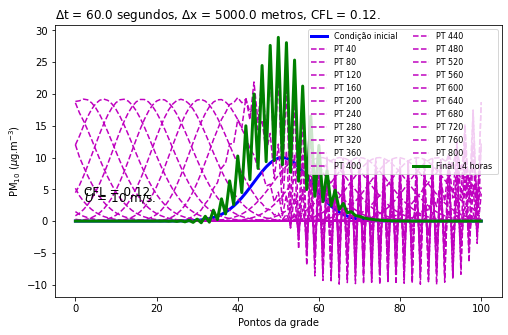

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio
import os
from matplotlib import animation, rc
from functions import *
# Condições do exercício
# ----------------------
hora    = 14
tempo   = hora*3600     # segundos
Nx      = 101           # pontos de grade
Nt      = int(hora*60)
print(Nt)
x, dx   = np.linspace(0, (Nx-1)*5000, Nx, retstep = True)
t, dt   = np.linspace(0, tempo, Nt, retstep = True)
U       = 10            # m/s
CFL     = U*dt/dx       # Courant number  CFL = 1, dt = 500

# Tipo de função, aproximação e contorno
# --------------------------------------
fun         =  "Gaussiana"          # Gaussiana, Retângulo
aprox       =  "Crank"           # ordem1, ordem4, leapfrog, Matsuno, Crank
cond_front  =  "periódica"          # fixa, periódica, radiacional
ylabel      =  "PM$_{10}$ ($\mu$g.m$^{-3}$)"
dP          =  40                  # Intervalo de passo de tempo
nr          =  10

C_ref = sol_analytical(fun, x, U, Nx, Nt, nr, t)
c = sol_num(aprox, cond_front, fun, CFL, nr, Nx, Nt, x, dx, U, t)
plot_sol_num(c, fun, aprox, cond_front, ylabel, dP, hora, Nt, CFL, U, dx, dt)
fig2gif(Nt, dP, dt, CFL, C_ref, c, ylabel, aprox, nr, cond_front, fun)

## Aproximação Leapfrog
Discretização no tempo e espaço das derivadas considerando diferenças centrais como segue:

$$
\frac{C^{n+1}_i - C^{n-1}_i}{2\Delta t} = -U*\frac{C^n_{i+1} - C^n_{i-1}}{2\Delta x}
$$

Se CFL é igual a $\gamma$, então temos

$$
C^{n+1}_i = C^{n-1}_i - \gamma(C^n_{i+1} - C^n_{i-1})
$$

para i = 0, consideramos usar o esquema de aproximação progressiva central no tempo:

$$
\frac{C^{n+1}_i - C^{n}_i}{\Delta t} = -U*\frac{C^n_{i+1} - C^n_{i-1}}{2\Delta x}
$$

Com isso temos

$$
C^{1}_i = C^{0}_i - \frac{\gamma}{2}(C^0_{i+1} - C^0_{i-1})
$$


In [10]:
np.diag(np.ones(len(x)))

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

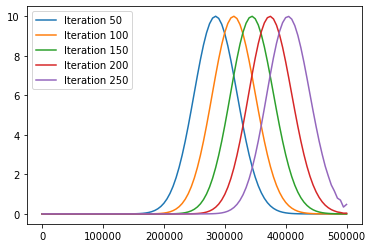

In [4]:
from __future__ import division
from scipy.sparse import spdiags
from scipy.sparse.linalg import spsolve
import numpy as np
import pylab
from functions import *

def make_advection_matrices(x, r):
    """Return matrices A and M for advection equations"""
    uns = np.ones(len(x))
    r   = uns*r
    diags = (-1, 0, 1)
    A = spdiags( [-beta*r, uns, beta*r], diags, len(x), len(x) )
    B = spdiags( [(1-beta)*r, uns, -(1-beta)*r], diags, len(x), len(x) )
    return A.tocsr(), B.tocsr()

def plot_iteration(x, c, iteration):
    """Plot the solver progress"""
    pylab.plot(x, c, label="Iteration %d" % iteration)

# Condições do exercício
# ----------------------
Nx = 101 # total number of mesh points
hora    = 5
tempo   = hora*3600     # segundos
Nx      = 101           # pontos de grade
Nt      = int(hora*60)
x, dx   = np.linspace(0, (Nx-1)*5000, Nx, retstep = True)
t, dt   = np.linspace(0, tempo, Nt, retstep = True)
U       = 10  #* np.ones(len(x)) # velocity field (constant)
beta = 0.5  # Crank-Nicolson parameter
CFL     = U*dt/dx
r       = CFL/2

# Initial conditions (peak function)
c_init = Conc(x, 10)

A, B = make_advection_matrices(x, r)
C = np.zeros((Nx, Nt))
C[:, 0] = c_init

for n in range(1, Nt):
    C[:, n] = spsolve(A, B*C[:, n-1])
    if n % 50 == 0:
        plot_iteration(x, C[:,n], n)

pylab.legend()
pylab.show()
